# Titanic Survivors Prediction

This is a project about predicting if a person would survive to the sinking of the Titanic.

This project will use an ensemble learning approach, which will include the following models:
1. Decision Trees
2. Support Vector Machines (SVM)
3. Naive Bayes
4. Logistic Regresion

The model will be the average of the four models described below.

## Loading Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Titanic Data

The dataset for this project is called "Titanic" which include the following features:

| Variable	         | Definition	                              | Key                    |
|--------------------|--------------------------------------------|------------------------|
| Id                 | Passenger Identificator                    |                        |
| Name               | Passenger Name                             |                        |
| Age	             | Age in years                               |                        |
| SibSp              | # of siblings / spouses aboard the Titanic |                        |
| ParCh              | # of parents / children aboard the Titanic |                        |
| Ticket             | Ticket number	                          |                        |
| Fare               | Passenger fare                             |                        |
| Cabin              | Cabin number                               |                        |
| Embarked           | Port of Embarkation	                      |C = Cherbourg, Q = Queenstown, S = Southampton|
| Class              | Ticket class                               | Lower, Middle, Upper   |
| Sex                | Sex                                        |                        |
| Survived           | Survived                                   | N = No, Y = Yes        |

The variable we want to predict is **Survived** which is a binary feature taking values:
* N: Didn't survived
* Y: Survived

In [2]:
#Loading dataset "Titanic"
titanic = pd.read_csv('data_titanic_proyecto.csv')
titanic.columns = ['Id', 'Name', 'Age', 'SibSp', 'ParCh', 'Ticket', 'Fare', 'Cabin', 'Embarked', 
                   'Class', 'Sex', 'Survived']

In [3]:
titanic.head()

,Id,Name,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked,Class,Sex,Survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


Now we're going to separate the data set into two:
* X: Contains all features that we're going to use in the model
* y: Contains the variable we want to predict

In [4]:
X = titanic.drop(['Name', 'Ticket', 'Cabin', 'Survived'], axis = 1)
y = pd.DataFrame(titanic['Survived'])
print('Number of rows for dataset X: ', X.shape[0], sep = '')
print('Number of rows for dataset y: ', y.shape[0], sep = '')

Number of rows for dataset X: 891
Number of rows for dataset y: 891


Check for NA values for each feature

In [5]:
total = X.isnull().sum().sort_values(ascending=False)
percent = (X.isnull().sum()/X.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Age,177,0.198653
Embarked,2,0.002245
Sex,0,0.000000
Class,0,0.000000
Fare,0,0.000000
ParCh,0,0.000000
SibSp,0,0.000000
Id,0,0.000000


## Feature Engineering: Part 1

### Dealing with NAs

For the column **Embarked** we will use a mode imputation. This means that the 2 missing values will get the mode for the whole column. In this case is **S: Southampton**

In [6]:
X['Embarked'].fillna(X['Embarked'].mode()[0], inplace=True)

For the column **Age** we'll use another approach: a linear model. But first, we need to change categorical features to numerical values. This is because the model will not contemplate ***string type*** tensors.

In [7]:
#For Embarked
embarked_label = np.unique(X['Embarked'].dropna())
embarked_index = np.arange(0,len(embarked_label))
embarked_dict = {'embarked_index': embarked_index, 'label': embarked_label}
embarked_dict = pd.DataFrame(embarked_dict, index=embarked_label)

#For Passenger Class
class_label = np.unique(X['Class'].dropna())
class_index = np.arange(0,len(class_label))
class_dict = {'class_index': class_index, 'label': class_label}
class_dict = pd.DataFrame(class_dict, index=class_label)

#For Passenger Sex
sex_label = np.unique(X['Sex'].dropna())
sex_index = np.arange(0,len(sex_label))
sex_dict = {'sex_index': sex_index, 'label': sex_label}
sex_dict = pd.DataFrame(sex_dict, index=sex_label)

#For Passenger Survival
survived_label = np.unique(y['Survived'].dropna())
survived_index = np.arange(0,len(survived_label))
survived_dict = {'survived_index': survived_index, 'label': survived_label}
survived_dict = pd.DataFrame(survived_dict, index=survived_label)

In [8]:
new_list = [None]*len(X['Embarked'])
for i in range(0,len(X['Embarked'])):
    temp = embarked_dict[embarked_dict.index==X['Embarked'][i]]
    new_list[i] = temp['embarked_index'][0]
len(new_list)
X['embarked_code'] = new_list

new_list = [None]*len(X['Class'])
for i in range(0,len(X['Class'])):
    temp = class_dict[class_dict.index==X['Class'][i]]
    new_list[i] = temp['class_index'][0]
len(new_list)
X['class_code'] = new_list

new_list = [None]*len(X['Sex'])
for i in range(0,len(X['Sex'])):
    temp = sex_dict[sex_dict.index==X['Sex'][i]]
    new_list[i] = temp['sex_index'][0]
len(new_list)
X['sex_code'] = new_list

new_list = [None]*len(y['Survived'])
for i in range(0,len(y)):
    temp = survived_dict[survived_dict.index==y['Survived'][i]]
    new_list[i] = temp['survived_index'][0]
len(new_list)
y['survived_code'] = new_list

In [9]:
X.head()

,Id,Age,SibSp,ParCh,Fare,Embarked,Class,Sex,embarked_code,class_code,sex_code
0,1,22.0,1,0,7.2500,S,Lower,M,2,0,1
1,2,38.0,1,0,71.2833,C,Upper,F,0,2,0
2,3,26.0,0,0,7.9250,S,Lower,F,2,0,0
3,4,35.0,1,0,53.1000,S,Upper,F,2,2,0
4,5,35.0,0,0,8.0500,S,Lower,M,2,0,1


In [10]:
y.head()

,Survived,survived_code
0,N,0
1,Y,1
2,Y,1
3,Y,1
4,N,0


Now, we need to generate the linear model in order to find the missing values for the age. This linear model will take **Age** as the variable we want to predict, using the following features:
* Embarked
* Class
* Sex
* SibSp
* Parch

In [11]:
def age_prediction(x,y):
    modelB = LinearRegression()
    modelB.fit(X=x, y=y)
    y_hat = modelB.predict(x)
    error = (1/2*np.mean((y_hat-y)**2))
    
    #building df
    df_dict = {'Id': X.dropna().Id, 'y_hat': y_hat}
    df = pd.DataFrame(df_dict)
    return(modelB.coef_, modelB.intercept_, error, modelB)

In [12]:
age_lm = age_prediction(X.dropna().drop(['Id', 'Embarked', 'Class', 'Sex', 'Age'], axis = 1), X['Age'].dropna())

Now that we have the linear model for the prediction of age in place, we'll predict the new values for **Age** in a new column called ***Age_lm***

In [13]:
X['age_lm'] = age_lm[3].predict(X.drop(['Id', 'Embarked', 'Class', 'Sex', 'Age'], axis = 1))
X['Age_LM'] = np.where(X['Age']>0, X['Age'], np.where(X['age_lm']>0, X['age_lm'], 1))
X = X.drop('age_lm', axis = 1)
X.head()

,Id,Age,SibSp,ParCh,Fare,Embarked,Class,Sex,embarked_code,class_code,sex_code,Age_LM
0,1,22.0,1,0,7.2500,S,Lower,M,2,0,1,22.0
1,2,38.0,1,0,71.2833,C,Upper,F,0,2,0,38.0
2,3,26.0,0,0,7.9250,S,Lower,F,2,0,0,26.0
3,4,35.0,1,0,53.1000,S,Upper,F,2,2,0,35.0
4,5,35.0,0,0,8.0500,S,Lower,M,2,0,1,35.0


Now we can check again the missing values

In [14]:
total = X.isnull().sum().sort_values(ascending=False)
percent = (X.isnull().sum()/X.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Age,177,0.198653
Age_LM,0,0.000000
sex_code,0,0.000000
class_code,0,0.000000
embarked_code,0,0.000000
Sex,0,0.000000
Class,0,0.000000
Embarked,0,0.000000
Fare,0,0.000000
ParCh,0,0.000000


We created a new column called **Age_LM** which contains no missing values. This will be our Age column from now on in every model.

## Train, Val, and Test Sets

We're going to split the dataset in three different sets:
* Train
* Validation (Val)
* Test

For these datsets, we'll use the following features:
1. Age_LM
2. SibSp
3. Parch
4. Fare
5. Embarked (code)
6. Class (code)
7. Sex (code)

And the variable we want to predict
1. Survived

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(['Age', 'Embarked', 'Class', 'Sex'], axis=1), 
    y, 
    test_size=0.2, 
    random_state=17
)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.3, 
    random_state=17
)

In [18]:
print('Number of rows in Train: ', len(X_train), ' (', round(100*len(X_train)/len(titanic),1), '%)', sep = '')
print('Number of rows in Val: ', len(X_val), ' (', round(100*len(X_val)/len(titanic),1), '%)', sep = '')
print('Number of rows in Train: ', len(X_test), ' (', round(100*len(X_test)/len(titanic),1), '%)', sep = '')

Number of rows in Train: 498 (55.9%)
Number of rows in Val: 214 (24.0%)
Number of rows in Train: 179 (20.1%)


## Exploration

### Histograms for numeric features

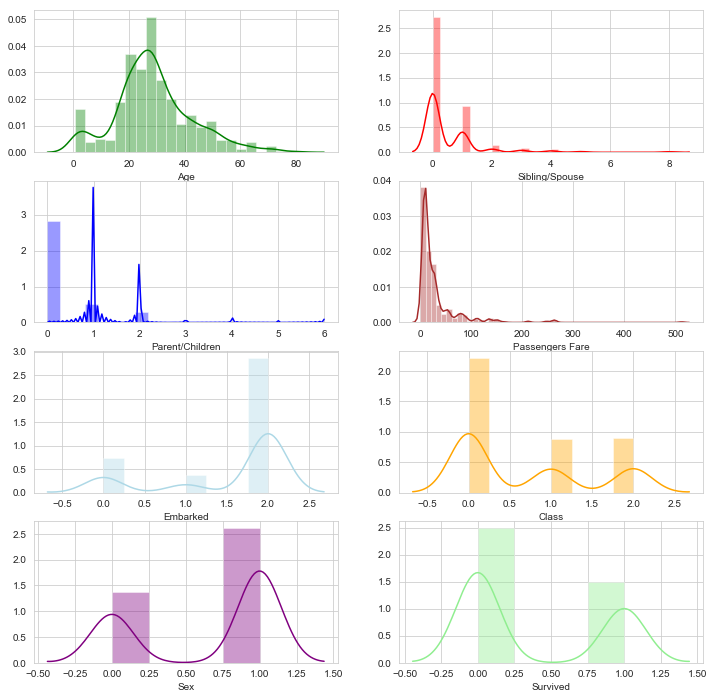

In [40]:
plt.figure(figsize=(12,12))
sns.set_style("whitegrid")
plt.subplot(4,2,1)
sns.distplot(X_train['Age_LM'], color='green', axlabel='Age')
plt.subplot(4,2,2)
sns.distplot(X_train['SibSp'], color='red', axlabel='Sibling/Spouse')
plt.subplot(4,2,3)
sns.distplot(X_train['ParCh'], color='blue', axlabel='Parent/Children')
plt.subplot(4,2,4)
sns.distplot(X_train['Fare'], color='brown', axlabel='Passengers Fare')
plt.subplot(4,2,5)
sns.distplot(X_train['embarked_code'], color='lightblue', axlabel='Embarked')
plt.subplot(4,2,6)
sns.distplot(X_train['class_code'], color='orange', axlabel='Class')
plt.subplot(4,2,7)
sns.distplot(X_train['sex_code'], color='purple', axlabel='Sex')
plt.subplot(4,2,8)
sns.distplot(y_train['survived_code'], color='lightgreen', axlabel='Survived')